In [1]:
import pickle

In [2]:
with open('/project_final/orbitals.pkl', 'rb') as f:
    orbitals = pickle.load(f)

with open('/project_final/maneuvers.pkl', 'rb') as f:
    maneuvers = pickle.load(f)

In [3]:
man_s3a = maneuvers['s3a']
man_fy2d = maneuvers['FY2D']
man_saral = maneuvers['srl']

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
baseline_s3a_df = pd.read_csv("/project_final/result/s3a_baseline_residuals.csv", parse_dates=["date"])
arima_s3a_df = pd.read_csv("/project_final/result/s3a_arima_residuals.csv", parse_dates=["date"])
xgb_diff_s3a_df = pd.read_csv("/project_final/result/s3a_xgb_residuals_diff.csv", parse_dates=["day_time"])
lstm_s3a_df = pd.read_csv("/project_final/result/s3a_lstm_residuals.csv", parse_dates=["day_time"])

baseline_fy2d_df = pd.read_csv("/project_final/result/fy2d_baseline_residuals.csv", parse_dates=["date"])
arima_fy2d_df = pd.read_csv("/project_final/result/fy2d_arima_residuals.csv", parse_dates=["date"])
xgb_diff_fy2d_df = pd.read_csv("/project_final/result/fy2d_xgb_residuals_diff.csv", parse_dates=["day_time"])
lstm_fy2d_df = pd.read_csv("/project_final/result/fy2d_lstm_residuals.csv", parse_dates=["day_time"])

baseline_saral_df = pd.read_csv("/project_final/result/saral_baseline_residuals.csv", parse_dates=["date"])
arima_saral_df = pd.read_csv("/project_final/result/saral_arima_residuals.csv", parse_dates=["date"])
xgb_diff_saral_df = pd.read_csv("/project_final/result/saral_xgb_residuals_diff.csv", parse_dates=["day_time"])
lstm_saral_df = pd.read_csv("/project_final/result/saral_lstm_residuals.csv", parse_dates=["day_time"])

In [6]:
xgb_diff_s3a_df.rename(columns={"day_time": "date"}, inplace=True)
xgb_diff_fy2d_df.rename(columns={"day_time": "date"}, inplace=True)
xgb_diff_saral_df.rename(columns={"day_time": "date"}, inplace=True)
lstm_s3a_df.rename(columns={"day_time": "date"}, inplace=True)
lstm_fy2d_df.rename(columns={"day_time": "date"}, inplace=True)
lstm_saral_df.rename(columns={"day_time": "date"}, inplace=True)

In [7]:
baseline_s3a_df.drop(columns=['actual','fitted'],inplace=True)
arima_s3a_df.drop(columns=['actual','fitted'],inplace=True)
xgb_diff_s3a_df.drop(columns=['actual','pred'],inplace=True)
lstm_s3a_df.drop(columns=['actual', 'pred'],inplace=True)

baseline_fy2d_df.drop(columns=['actual','fitted'],inplace=True)
arima_fy2d_df.drop(columns=['actual','fitted'],inplace=True)
xgb_diff_fy2d_df.drop(columns=['actual','pred'],inplace=True)
lstm_fy2d_df.drop(columns=['actual', 'pred'],inplace=True)

baseline_saral_df.drop(columns=['actual','fitted'],inplace=True)
arima_saral_df.drop(columns=['actual','fitted'],inplace=True)
xgb_diff_saral_df.drop(columns=['actual','pred'],inplace=True)
lstm_saral_df.drop(columns=['actual', 'pred'],inplace=True)

In [8]:
def align_to_reference_dates(
    ref_df,
    *other_dfs,
    date_col="date",
    strict=True,
    abs_residual=True
):

    ref = ref_df.copy()
    ref[date_col] = pd.to_datetime(ref[date_col], errors="coerce")
    ref = ref.dropna(subset=[date_col]).sort_values(date_col)

    start, end = ref[date_col].min(), ref[date_col].max()
    ref_dates = pd.DatetimeIndex(ref[date_col].unique()) if strict else None

    aligned_list = []

    def _post_process(df):
        
        if abs_residual and "residual" in df.columns:
            df["residual"] = df["residual"].abs()
        
        df = df.sort_values(date_col).reset_index(drop=True)
        # df[date_col] = df[date_col].dt.strftime(fmt)
        return df

    # 
    for df in other_dfs:
        d = df.copy()
        d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
        d = d.dropna(subset=[date_col])

        if strict:
            # 
            d = d[d[date_col].isin(ref_dates)]
        else:
            # 
            d = d[(d[date_col] >= start) & (d[date_col] <= end)]

        aligned_list.append(_post_process(d))

    # 
    ref_out = ref.copy()
    if abs_residual and "residual" in ref_out.columns:
        ref_out["residual"] = ref_out["residual"].abs()
    ref_out = ref_out.sort_values(date_col).reset_index(drop=True)

    return (ref_out, *aligned_list)

In [9]:
print(baseline_s3a_df.head(1), "\n", arima_s3a_df.head(1), "\n", xgb_diff_s3a_df.head(1), "\n", lstm_s3a_df.head(1))

        date  residual
0 2016-03-04  0.000062 
         date      residual
0 2016-03-04 -7.399500e-08 
         date  residual
0 2016-03-12 -0.082285 
         date  residual
0 2016-03-09  0.155023


In [10]:
xgb_diff_s3a_aligned, lstm_s3a_aligned, arima_s3a_aligned, baseline_s3a_aligned = align_to_reference_dates(
    xgb_diff_s3a_df, lstm_s3a_df, arima_s3a_df, baseline_s3a_df,
    date_col="date", strict=True, abs_residual=True
)

In [11]:
print(baseline_s3a_aligned.head(1), "\n", arima_s3a_aligned.head(1), "\n", xgb_diff_s3a_aligned.head(1), "\n", lstm_s3a_aligned.head(1))

        date      residual
0 2016-03-12  4.788452e-08 
         date      residual
0 2016-03-12  3.894827e-08 
         date  residual
0 2016-03-12  0.082285 
         date  residual
0 2016-03-12  0.079569


In [12]:
print(baseline_fy2d_df.head(1), "\n", arima_fy2d_df.head(1), "\n", xgb_diff_fy2d_df.head(1), "\n", lstm_fy2d_df.head(1))

        date  residual
0 2011-01-27  0.000004 
         date      residual
0 2011-01-27  1.000031e-07 
         date  residual
0 2011-02-01  0.141243 
         date  residual
0 2011-01-30 -0.072843


In [13]:
xgb_diff_fy2d_aligned, lstm_fy2d_aligned, arima_fy2d_aligned, baseline_fy2d_aligned = align_to_reference_dates(
    xgb_diff_fy2d_df, lstm_fy2d_df, arima_fy2d_df, baseline_fy2d_df,
    date_col="date", strict=True, abs_residual=True
)

In [14]:
print(baseline_fy2d_aligned.head(1), "\n", arima_fy2d_aligned.head(1), "\n", xgb_diff_fy2d_aligned.head(1), "\n", lstm_fy2d_aligned.head(1))

        date      residual
0 2011-02-01  5.920002e-08 
         date      residual
0 2011-02-01  6.688166e-08 
         date  residual
0 2011-02-01  0.141243 
         date  residual
0 2011-02-01  0.081596


In [15]:
print(baseline_saral_df.head(1), "\n", arima_saral_df.head(1), "\n", xgb_diff_saral_df.head(1), "\n", lstm_saral_df.head(1))

        date  residual
0 2013-03-10  0.000063 
         date      residual
0 2013-03-10  4.357328e-08 
         date  residual
0 2013-03-17  -1.47788 
         date  residual
0 2013-03-14 -0.698613


In [16]:
xgb_diff_saral_aligned, lstm_saral_aligned, arima_saral_aligned, baseline_saral_aligned = align_to_reference_dates(
    xgb_diff_saral_df, lstm_saral_df, arima_saral_df, baseline_saral_df,
    date_col="date", strict=True, abs_residual=True
)

In [17]:
print(baseline_saral_aligned.head(1), "\n", arima_saral_aligned.head(1), "\n", xgb_diff_saral_aligned.head(1), "\n", lstm_saral_aligned.head(1))

        date      residual
0 2013-03-17  1.054134e-07 
         date      residual
0 2013-03-17  3.410752e-09 
         date  residual
0 2013-03-17   1.47788 
         date  residual
0 2013-03-17  0.048934


In [18]:
lstm_saral_aligned.head()

,date,residual
0,2013-03-17,0.048934
1,2013-03-18,0.000246
2,2013-03-20,0.002003
3,2013-03-21,0.000851
4,2013-03-22,0.002010


## man align with res abs

In [19]:
man_dates_s3a = pd.to_datetime(man_s3a["median_day_time"])
man_dates_s3a = man_dates_s3a.sort_values()

man_dates_fy2d = pd.to_datetime(man_fy2d["median_day_time"])
man_dates_fy2d = man_dates_fy2d.sort_values()

man_dates_saral = pd.to_datetime(man_saral["median_day_time"])
man_dates_saral = man_dates_saral.sort_values()

In [20]:
man_dates_s3a = man_dates_s3a[6:-1]
man_dates_fy2d = man_dates_fy2d.copy()
man_dates_saral = man_dates_saral[7:-1]

## threshold

In [21]:
def convert_timestamp_series_to_epoch(series):
    return (
        (series - pd.Timestamp(year=1970, month=1, day=1)) // pd.Timedelta(seconds=1)
    ).values

In [22]:
def compute_simple_matching_precision_recall_for_one_threshold(
    matching_max_days,
    threshold,
    series_ground_truth_manoeuvre_timestamps,
    series_predictions,
):
    matching_max_distance_seconds = pd.Timedelta(days=matching_max_days).total_seconds()
    dict_predictions_to_ground_truth = {}
    dict_ground_truth_to_predictions = {}

    manoeuvre_timestamps_seconds = convert_timestamp_series_to_epoch(series_ground_truth_manoeuvre_timestamps)
    pred_time_stamps_seconds = convert_timestamp_series_to_epoch(series_predictions.index)
    predictions = series_predictions.to_numpy()

    for i in range(predictions.shape[0]):
        if predictions[i] >= threshold:
            left_index = np.searchsorted(
                manoeuvre_timestamps_seconds, pred_time_stamps_seconds[i]
            )

            if left_index != 0:
                left_index -= 1

            index_of_closest = left_index

            if (left_index < len(series_ground_truth_manoeuvre_timestamps) - 1) and (
                abs(manoeuvre_timestamps_seconds[left_index] - pred_time_stamps_seconds[i])
                > abs(manoeuvre_timestamps_seconds[left_index + 1] - pred_time_stamps_seconds[i])
            ):
                index_of_closest = left_index + 1

            diff = abs(manoeuvre_timestamps_seconds[index_of_closest] - pred_time_stamps_seconds[i])

            if diff < matching_max_distance_seconds:
                dict_predictions_to_ground_truth[i] = (index_of_closest, diff)
                if index_of_closest in dict_ground_truth_to_predictions:
                    dict_ground_truth_to_predictions[index_of_closest].append(i)
                else:
                    dict_ground_truth_to_predictions[index_of_closest] = [i]

    positive_prediction_indices = np.argwhere(predictions >= threshold)[:, 0]
    list_false_positives = [
        pred_ind for pred_ind in positive_prediction_indices if pred_ind not in dict_predictions_to_ground_truth
    ]
    list_false_negatives = [
        true_ind for true_ind in np.arange(0, len(series_ground_truth_manoeuvre_timestamps))
        if true_ind not in dict_ground_truth_to_predictions
    ]

    precision = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_positives)) if (len(dict_ground_truth_to_predictions) + len(list_false_positives)) > 0 else 0.0
    recall = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) if (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) > 0 else 0.0

    return (precision, recall)

In [23]:
s3a_baseline_thresholds = np.sort(baseline_s3a_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
s3a_baseline_precision_3d, s3a_baseline_recall_3d = [], []

for threshold in s3a_baseline_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_s3a,
        series_predictions=baseline_s3a_aligned.set_index("date")["residual"]
    )
    s3a_baseline_precision_3d.append(p)
    s3a_baseline_recall_3d.append(r)
    
    
s3a_arima_thresholds = np.sort(arima_s3a_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
s3a_arima_precision_3d, s3a_arima_recall_3d = [], []

for threshold in s3a_arima_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_s3a,
        series_predictions=arima_s3a_aligned.set_index("date")["residual"]
    )
    s3a_arima_precision_3d.append(p)
    s3a_arima_recall_3d.append(r)
    
s3a_xgb_diff_thresholds = np.sort(xgb_diff_s3a_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
s3a_xgb_diff_precision_3d, s3a_xgb_diff_recall_3d = [], []

for threshold in s3a_xgb_diff_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_s3a,
        series_predictions=xgb_diff_s3a_aligned.set_index("date")["residual"]
    )
    s3a_xgb_diff_precision_3d.append(p)
    s3a_xgb_diff_recall_3d.append(r)
    
s3a_lstm_thresholds = np.sort(lstm_s3a_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
s3a_lstm_precision_3d, s3a_lstm_recall_3d = [], []

for threshold in s3a_lstm_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_s3a,
        series_predictions=lstm_s3a_aligned.set_index("date")["residual"]
    )
    s3a_lstm_precision_3d.append(p)
    s3a_lstm_recall_3d.append(r)

In [24]:
fy2d_baseline_thresholds = np.sort(baseline_fy2d_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
fy2d_baseline_precision_3d, fy2d_baseline_recall_3d = [], []

for threshold in fy2d_baseline_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_fy2d,
        series_predictions=baseline_fy2d_aligned.set_index("date")["residual"]
    )
    fy2d_baseline_precision_3d.append(p)
    fy2d_baseline_recall_3d.append(r)
    
    
fy2d_arima_thresholds = np.sort(arima_fy2d_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
fy2d_arima_precision_3d, fy2d_arima_recall_3d = [], []

for threshold in fy2d_arima_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_fy2d,
        series_predictions=arima_fy2d_aligned.set_index("date")["residual"]
    )
    fy2d_arima_precision_3d.append(p)
    fy2d_arima_recall_3d.append(r)
    
fy2d_xgb_diff_thresholds = np.sort(xgb_diff_fy2d_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
fy2d_xgb_diff_precision_3d, fy2d_xgb_diff_recall_3d = [], []

for threshold in fy2d_xgb_diff_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_fy2d,
        series_predictions=xgb_diff_fy2d_aligned.set_index("date")["residual"]
    )
    fy2d_xgb_diff_precision_3d.append(p)
    fy2d_xgb_diff_recall_3d.append(r)
    
fy2d_lstm_thresholds = np.sort(lstm_fy2d_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
fy2d_lstm_precision_3d, fy2d_lstm_recall_3d = [], []

for threshold in fy2d_lstm_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_fy2d,
        series_predictions=lstm_fy2d_aligned.set_index("date")["residual"]
    )
    fy2d_lstm_precision_3d.append(p)
    fy2d_lstm_recall_3d.append(r)

In [25]:
saral_baseline_thresholds = np.sort(baseline_saral_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
saral_baseline_precision_3d, saral_baseline_recall_3d = [], []

for threshold in saral_baseline_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_saral,
        series_predictions=baseline_saral_aligned.set_index("date")["residual"]
    )
    saral_baseline_precision_3d.append(p)
    saral_baseline_recall_3d.append(r)
    
    
saral_arima_thresholds = np.sort(arima_saral_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
saral_arima_precision_3d, saral_arima_recall_3d = [], []

for threshold in saral_arima_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_saral,
        series_predictions=arima_saral_aligned.set_index("date")["residual"]
    )
    saral_arima_precision_3d.append(p)
    saral_arima_recall_3d.append(r)
    
saral_xgb_diff_thresholds = np.sort(xgb_diff_saral_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
saral_xgb_diff_precision_3d, saral_xgb_diff_recall_3d = [], []

for threshold in saral_xgb_diff_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_saral,
        series_predictions=xgb_diff_saral_aligned.set_index("date")["residual"]
    )
    saral_xgb_diff_precision_3d.append(p)
    saral_xgb_diff_recall_3d.append(r)
    
saral_lstm_thresholds = np.sort(lstm_saral_aligned['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
saral_lstm_precision_3d, saral_lstm_recall_3d = [], []

for threshold in saral_lstm_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_saral,
        series_predictions=lstm_saral_aligned.set_index("date")["residual"]
    )
    saral_lstm_precision_3d.append(p)
    saral_lstm_recall_3d.append(r)

### F1

In [26]:
def find_best_f1(thresholds, precision_list, recall_list):
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0.0 for p, r in zip(precision_list, recall_list)]
    max_index = int(np.argmax(f1_scores))
    return (
        thresholds[max_index],      # 
        f1_scores[max_index],       # 
        precision_list[max_index],  # 
        recall_list[max_index]      # 
    )

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 
def clean_pr(recall, precision, thresholds=None, drop_last=True, clip_max=0.995,
             enforce_monotone=True):
    r = np.asarray(recall, dtype=float)
    p = np.asarray(precision, dtype=float)
    t = None if thresholds is None else np.asarray(thresholds, dtype=float)

    # 
    if drop_last and len(r) > 1:
        r, p = r[:-1], p[:-1]
        if t is not None and len(t) >= len(r):
            t = t[:len(r)]

    
    order = np.argsort(r)
    r, p = r[order], p[order]
    if t is not None:
        t = t[order]

    
    ur, idx = np.unique(r, return_index=True)
    
    max_p = []
    pick_t = [] if t is not None else None
    for i, rr in enumerate(ur):
        mask = (r == rr)
        p_grp = p[mask]
        j = np.argmax(p_grp)
        max_p.append(p_grp[j])
        if t is not None:
            pick_t.append(t[mask][j])
    r, p = ur, np.array(max_p)
    if t is not None:
        t = np.array(pick_t)

    
    if clip_max is not None:
        p = np.clip(p, 0.0, clip_max)

    
    if enforce_monotone and len(p) > 1:
        
        p = np.maximum.accumulate(p[::-1])[::-1]

    return r, p, t

from matplotlib.colors import to_rgba_array

def best_fbeta_idx(precision, recall, beta=1.0):
    p = np.asarray(precision, dtype=float)
    r = np.asarray(recall, dtype=float)
    beta2 = beta * beta
    denom = beta2 * p + r
    f = np.where(denom > 0, (1 + beta2) * p * r / denom, 0.0)
    m = np.nanmax(f)
    cand = np.flatnonzero(f == m)
    
    cand = cand[np.argmax(r[cand])] if len(cand) > 1 else int(cand[0])
    return cand, f

def plot_pr_multi(
    ax,
    series,
    step=True,
    show_best=True,
    beta=1.0,
    marker_size=60,
    legend_loc="lower left",
    legend_fontsize=10,
    xlim=(0.15, 1.05),
    ylim=(0.15, 1.05),
    title=None,
    use_safe_colors=True,
):
    
    if use_safe_colors:
        all_colors = to_rgba_array(plt.cm.tab10.colors)
        safe_colors = [
            c for c in all_colors
            if not (
                (c[0] > 0.7 and c[1] < 0.3 and c[2] < 0.3)  
                or (c[0] < 0.3 and c[1] > 0.6 and c[2] < 0.3)  
            )
        ]
        
        for i, s in enumerate(series):
            s['color'] = safe_colors[i % len(safe_colors)]

    ds = "steps-post" if step else None
    handles = []
    used_positions = []  

    for i, s in enumerate(series):
        r, p, _ = clean_pr(s['recall'], s['precision'], s.get('thresholds'))
        line, = ax.plot(
            r, p, lw=2, label=s['label'], drawstyle=ds,
            color=s.get('color', None)
        )
        handles.append(line)

        if show_best:
            idx, fvals = best_fbeta_idx(p, r, beta=beta)
            best_point = (r[idx], p[idx])

            
            offset_x, offset_y = -15, -15
            for prev_x, prev_y in used_positions:
                if abs(prev_x - best_point[0]) < 0.05 and abs(prev_y - best_point[1]) < 0.05:
                    offset_y += 20  
                    offset_x += 15

            used_positions.append(best_point)

            ax.scatter(*best_point, s=marker_size, zorder=5, color=line.get_color())

            # ax.annotate(
            #     f"F{beta:.0f}={fvals[idx]:.2f}",
            #     best_point,
            #     xytext=(offset_x, offset_y),
            #     textcoords="offset points",
            #     fontsize=9,
            #     bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7)
            # )

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(loc=legend_loc, fontsize=legend_fontsize)
    if title:
        ax.set_title(title)

    return handles

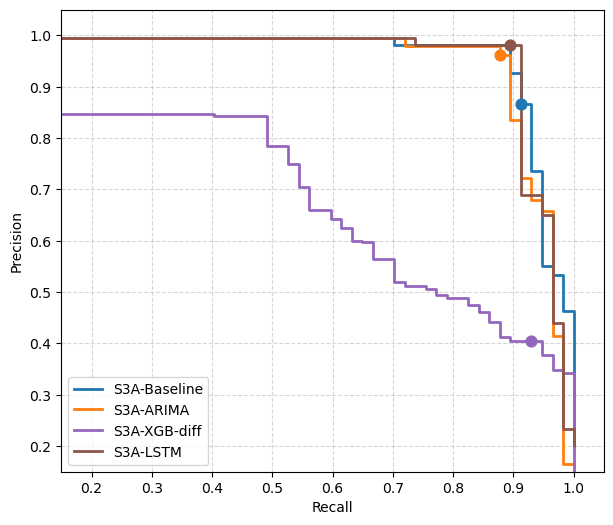

In [28]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_pr_multi(
    ax,
    [
        {'recall': s3a_baseline_recall_3d, 'precision': s3a_baseline_precision_3d, 'label': 'S3A-Baseline'},
        {'recall': s3a_arima_recall_3d,    'precision': s3a_arima_precision_3d,    'label': 'S3A-ARIMA'},
        {'recall': s3a_xgb_diff_recall_3d, 'precision': s3a_xgb_diff_precision_3d, 'label': 'S3A-XGB-diff'},
        {'recall': s3a_lstm_recall_3d,     'precision': s3a_lstm_precision_3d,     'label': 'S3A-LSTM'}
    ],
    use_safe_colors=True,
    beta=2.0, show_best=True
)
plt.show()

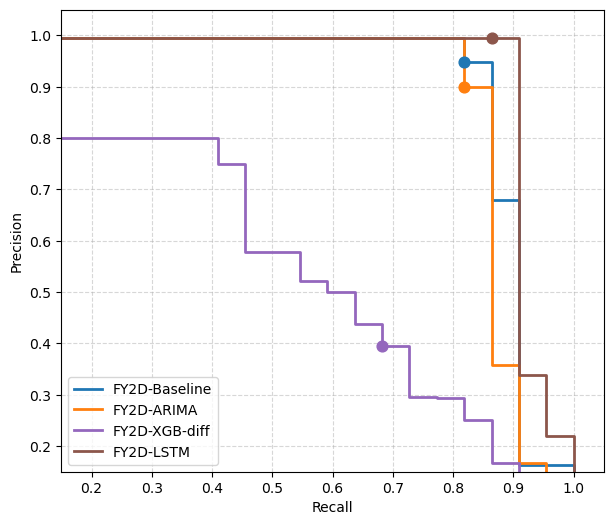

In [29]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_pr_multi(
    ax,
    [
        {'recall': fy2d_baseline_recall_3d, 'precision': fy2d_baseline_precision_3d, 'label': 'FY2D-Baseline'},
        {'recall': fy2d_arima_recall_3d,    'precision': fy2d_arima_precision_3d,    'label': 'FY2D-ARIMA'},
        {'recall': fy2d_xgb_diff_recall_3d, 'precision': fy2d_xgb_diff_precision_3d, 'label': 'FY2D-XGB-diff'},
        {'recall': fy2d_lstm_recall_3d,     'precision': fy2d_lstm_precision_3d,     'label': 'FY2D-LSTM'}
    ],
    use_safe_colors=True, show_best=True, beta=2.0
)
plt.show()

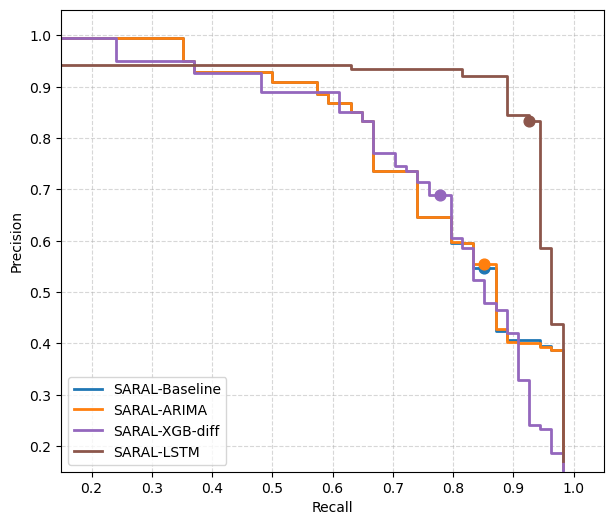

In [30]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_pr_multi(
    ax,
    [
        {'recall': saral_baseline_recall_3d, 'precision': saral_baseline_precision_3d, 'label': 'SARAL-Baseline'},
        {'recall': saral_arima_recall_3d,    'precision': saral_arima_precision_3d,    'label': 'SARAL-ARIMA'},
        {'recall': saral_xgb_diff_recall_3d, 'precision': saral_xgb_diff_precision_3d, 'label': 'SARAL-XGB-diff'},
        {'recall': saral_lstm_recall_3d,     'precision': saral_lstm_precision_3d,     'label': 'SARAL-LSTM'}
    ],
    use_safe_colors=True, show_best=True, beta=2.0
)
plt.show()